In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

sys.path.append("../")
DATASET_PATH = "../english_cleaned_lyrics.csv"

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from preprocessing.build_dataset import get_dataset_splits
from preprocessing.build_dataset import LABELS
from preprocessing.build_dataset import get_label_encoder
from preprocessing.SongsDataset import SongsDataset
from preprocessing.TokenizeTransformer import TokenizeTransformer
from preprocessing.RemoveStopwordsTransform import RemoveStopwordsTransform
from preprocessing.RemovePunctuationTransformer import RemovePunctuationTransformer
from torchvision import transforms
from torch.utils.data import DataLoader
from nltk.tokenize import word_tokenize
from preprocessing.GloveEmbeddingTransformer import GloveEmbeddingTransformer
import time
import itertools
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = get_dataset_splits(DATASET_PATH, train_size_p=0.8, val_size_p=0.1)

tokenizer_transform = TokenizeTransformer(word_tokenize)
all_words = list(itertools.chain.from_iterable(tokenizer_transform(X_train)))
glove_embedding_transform = GloveEmbeddingTransformer(all_words, 30000, 600)

train_dataset = SongsDataset(
	X_train, 
	y_train, 
	transform=transforms.Compose([tokenizer_transform, glove_embedding_transform])
)

val_dataset = SongsDataset(
	X_val, 
	y_val, 
	transform=transforms.Compose([tokenizer_transform, glove_embedding_transform])
)

test_dataset = SongsDataset(
	X_test, 
	y_test, 
	transform=transforms.Compose([tokenizer_transform, glove_embedding_transform])
)

In [4]:
BATCH_SIZE = 64

train_loader = DataLoader(
	train_dataset,
	shuffle=True,
	batch_size=BATCH_SIZE
)

val_loader = DataLoader(
	val_dataset,
	shuffle=True,
	batch_size=BATCH_SIZE
)

test_loader = DataLoader(
	test_dataset,
	shuffle=True,
	batch_size=BATCH_SIZE
)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class LSTM_Model(nn.Module):
	
	def __init__(self, init_embeddings, hidden_size, num_classes):
		super(LSTM_Model, self).__init__()

		self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(init_embeddings).float())
		self.lstm = nn.LSTM(input_size=100, hidden_size=hidden_size, batch_first=True)  
		
		self.classifier = nn.Sequential(
			nn.MaxPool1d(kernel_size=hidden_size),
			nn.Flatten(),
			nn.Linear(600, num_classes)
		)


	def forward(self, x):
		output = self.embedding(x)
		output = self.lstm(output)[0]
		output = self.classifier(output)
		return output


model = LSTM_Model(glove_embedding_transform.get_embeddings(), 50, 4).to(device)
optimizer = torch.optim.RMSprop(model.parameters())
loss_fn = nn.CrossEntropyLoss()
EPOCHS_NUM = 10

In [6]:
def train_step(model, data_loader, loss_fn, optimizer, device):

	loss_val = 0
	predictions = np.array([])
	y_true = np.array([])

	for i, (x, y) in enumerate(tqdm(data_loader)):
		x = x.to(device)
		y = y.to(device)

		optimizer.zero_grad()

		y_pred = model(x)
		loss = loss_fn(y_pred, y)
		loss.backward()

		optimizer.step()
		torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

		y_pred = torch.argmax(y_pred, dim=1)

		loss_val += loss.item()
		predictions = np.append(predictions, y_pred.cpu().detach().numpy())
		y_true = np.append(y_true, y.cpu().detach().numpy())

	predictions = predictions.flatten()
	accuracy = accuracy_score(y_true.flatten(), predictions)
	loss_val /= len(data_loader)

	return loss_val, accuracy
	


def val_step(model, data_loader, loss_fn, device):
	
	loss_val = 0
	predictions = np.array([])
	y_true = np.array([])

	with torch.no_grad():
		for i, (x, y) in enumerate(tqdm(data_loader)):
			x = x.to(device)
			y = y.to(device)

			y_pred = model(x)
			loss = loss_fn(y_pred, y)

			y_pred = torch.argmax(y_pred, dim=1)

			loss_val += loss.item()
			predictions = np.append(predictions, y_pred.cpu().detach().numpy())
			y_true = np.append(y_true, y.cpu().detach().numpy())

	predictions = predictions.flatten()
	accuracy = accuracy_score(y_true.flatten(), predictions)
	loss_val /= len(data_loader)

	return loss_val, accuracy

writer = SummaryWriter()

for epoch in range(EPOCHS_NUM):
	loss, acc = train_step(model, train_loader, loss_fn, optimizer, device)
	writer.add_scalar("Loss/train", loss, epoch)
	writer.add_scalar("Accuracy/train", acc, epoch)

	loss, acc = val_step(model, val_loader, loss_fn, device)
	writer.add_scalar("Loss/val", loss, epoch)
	writer.add_scalar("Accuracy/val", acc, epoch)

writer.close()

100%|██████████| 252/252 [00:02<00:00, 104.55it/s]


In [7]:
with torch.no_grad():
	predictions = []
	y_true = []

	for i, (x, y) in enumerate(tqdm(test_loader)):
		x = x.to(device)
		y = y.to(device)
		
		y_pred = model(x)
		y_pred = torch.argmax(y_pred, dim=1)

		predictions = np.append(predictions, y_pred.cpu().detach().numpy())
		y_true = np.append(y_true, y.cpu().detach().numpy())

	predictions = predictions.flatten()
	y_true = y_true.flatten()


label_encoder = get_label_encoder("../english_cleaned_lyrics.csv")

conf_matrix = confusion_matrix(y_true, predictions)

100%|██████████| 252/252 [00:02<00:00, 104.28it/s]


<AxesSubplot:>

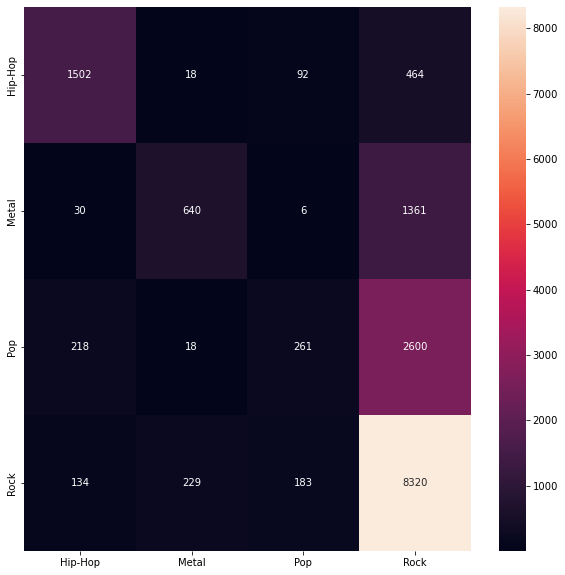

In [8]:
df_cm = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(10, 10))
sn.heatmap(df_cm, annot=True, fmt="d")

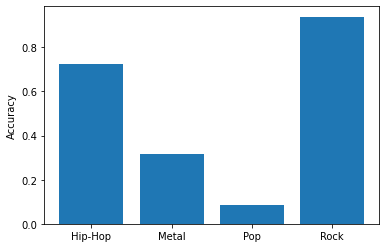

In [9]:
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

plt.bar(label_encoder.classes_, accuracy_per_class)
plt.ylabel("Accuracy")
plt.show()